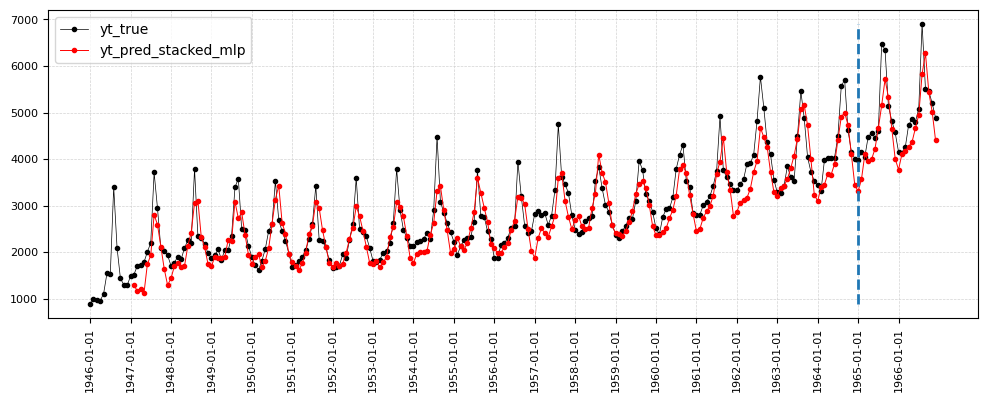

,Metrics,yt_pred_stacked_mlp
0,MSE Train,132016.18
1,MSE Test,277555.42
2,MAE Train,278.07
3,MAE Test,410.07


In [4]:
# =============================================================================
#
# Pronositco usando un stacked MLP
#
# =============================================================================
import warnings

warnings.filterwarnings("ignore")

#
# Carga de datos
#
import nbimporter  #  type: ignore
import functions  #  type: ignore


df_orig = functions.load_data()
df_orig.head()






#
# Construcción de la matriz de regresores
#
df_orig = functions.make_lagged_ts(
    df=df_orig,
    p_max=13,
    y_column="yt_true",
    fmt="lagged_{}m",
)
df_orig.head()







#
# Remoción de los valores faltantes
#
df_dropna = df_orig.dropna()
df_dropna.head()






#
# División de los datos en entrenamiento y prueba
#
(
    X_complete,
    y_complete,
    X_train,
    y_train,
    X_test,
    y_test,
) = functions.train_test_split(
    df=df_dropna,
    x_columns=[f"lagged_{i}m" for i in range(1, 13)],
    y_column="yt_true",
)
X_complete.head()







#
# Pronostico usando una red neuronal tipo MLP
#
from sklearn.pipeline import Pipeline  #  type: ignore
from sklearn.preprocessing import MinMaxScaler  #  type: ignore
from sklearn.compose import TransformedTargetRegressor  #  type: ignore
from sklearn.neural_network import MLPRegressor  #  type: ignore


# Crea un pipeline para automatizar la creacion de un modelo
def make_pipeline_from_model(model):
    """Create a pipeline."""
    return Pipeline(
        [
            (
                "scaler",
                MinMaxScaler(),
            ),
            (
                "regressor",
                TransformedTargetRegressor(
                    regressor=model,
                    transformer=MinMaxScaler(),
                ),
            ),
        ]
    )
  
  
  
  
  
  
  


#
# Entrenamiento y pronostico del Modelo 0
#
hidden = 16

pipeline_0 = make_pipeline_from_model(
    model=MLPRegressor(
        hidden_layer_sizes=(hidden,),
        activation="relu",
        learning_rate="adaptive",
        momentum=0.01,
        learning_rate_init=0.2,
        max_iter=10000,
        random_state=123456,
    )
)

pipeline_0.fit(X_train, y_train)

X_train_stacked = X_train.copy()
X_train_stacked["forecast_pipeline_0"] = pipeline_0.predict(X_train)

X_complete_stacked = X_complete.copy()
X_complete_stacked["forecast_pipeline_0"] = pipeline_0.predict(X_complete)

X_complete_stacked






#
# Entrenamiento y pronostico del Modelo 1
#
hidden = 16

pipeline_1 = make_pipeline_from_model(
    model=MLPRegressor(
        hidden_layer_sizes=(hidden,),
        activation="relu",
        learning_rate="adaptive",
        momentum=0.01,
        learning_rate_init=0.2,
        max_iter=10000,
        random_state=12345,
    )
)

pipeline_1.fit(X_train_stacked, y_train)


df_dropna[f"yt_pred_stacked_mlp"] = pipeline_1.predict(X_complete_stacked)

df_dropna



#
# Gráfica de los pronósticos
#
df_orig.loc[df_dropna.index, f"yt_pred_stacked_mlp"] = df_dropna[f"yt_pred_stacked_mlp"]

functions.plot_time_series(df=df_orig, yt_col="yt_true")

#
# Almacenamiento de los resultados
#
functions.save_forecasts(df_orig)

#
# Métricas de error
#
metrics = functions.compute_evaluation_metrics(df_orig.dropna())
functions.save_metrics(metrics)
metrics

